In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [26]:
df = pd.read_csv('../data/raw/hmQOVnDvRN.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [27]:
# Check TotalCharges column - known issue in this dataset
print("TotalCharges unique values (first 20):")
print(df['TotalCharges'].value_counts().head(20))

# Check for non-numeric values
print("\nNon-numeric TotalCharges values:")
non_numeric = df[pd.to_numeric(df['TotalCharges'], errors='coerce').isna()]
print(f"Count of non-numeric values: {len(non_numeric)}")
print(non_numeric[['customerID', 'tenure', 'TotalCharges']].head())

TotalCharges unique values (first 20):
TotalCharges
20.2     11
         11
19.75     9
19.65     8
19.9      8
20.05     8
19.55     7
45.3      7
19.45     6
20.25     6
20.15     6
20.45     5
20.3      5
19.4      4
75.3      4
44.4      4
19.3      4
19.85     4
20.5      4
70.6      4
Name: count, dtype: int64

Non-numeric TotalCharges values:
Count of non-numeric values: 11
      customerID  tenure TotalCharges
488   4472-LVYGI       0             
753   3115-CZMZD       0             
936   5709-LVOEQ       0             
1082  4367-NUYAO       0             
1340  1371-DWPAZ       0             


In [28]:
# Fix TotalCharges data type
def clean_total_charges(df):
    """Clean TotalCharges column by handling empty strings and converting to float"""
    df = df.copy()
    
    # Replace empty strings with NaN
    df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
    
    # Convert to numeric
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    
    # For customers with 0 tenure, set TotalCharges to 0
    df.loc[df['tenure'] == 0, 'TotalCharges'] = 0
    
    # For others with missing TotalCharges, estimate based on MonthlyCharges * tenure
    missing_mask = df['TotalCharges'].isna() & (df['tenure'] > 0)
    df.loc[missing_mask, 'TotalCharges'] = df.loc[missing_mask, 'MonthlyCharges'] * df.loc[missing_mask, 'tenure']
    
    return df

# Apply cleaning
df_clean = clean_total_charges(df)

print("After cleaning:")
print(f"Missing TotalCharges: {df_clean['TotalCharges'].isnull().sum()}")
print(f"TotalCharges data type: {df_clean['TotalCharges'].dtype}")

After cleaning:
Missing TotalCharges: 0
TotalCharges data type: float64


In [29]:
# Check for any other data inconsistencies
def check_data_consistency(df):
    """Check for data inconsistencies across the dataset"""
    print("Data Consistency Check:")
    print("=" * 50)
    
    # Check categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    categorical_cols = categorical_cols[categorical_cols != 'customerID']
    
    for col in categorical_cols:
        unique_vals = df[col].unique()
        print(f"{col}: {unique_vals}")
        
    # Check numerical ranges
    print("\nNumerical Columns Summary:")
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    print(df[numerical_cols].describe())

check_data_consistency(df_clean)

Data Consistency Check:
gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']

Numerical Columns Summary:
       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7043.000000
mean        0.162147    32.371149       64.761692   2279.734304
std         0.368612    24.559481       30.090047   2266

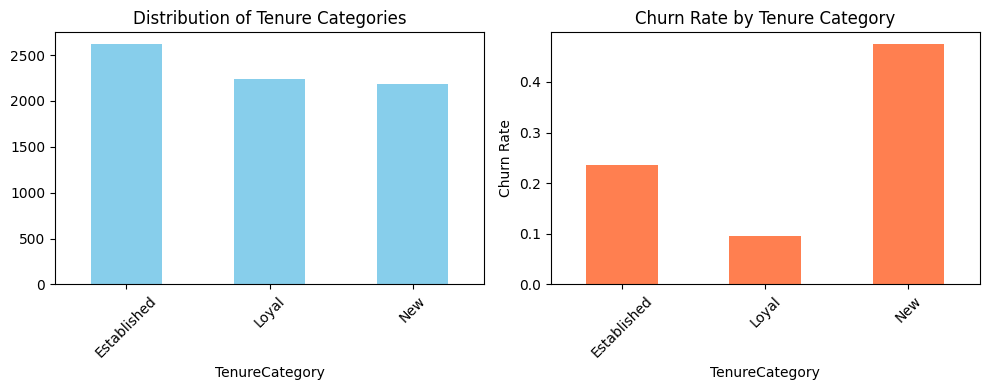

Tenure Categories Distribution:
TenureCategory
Established    2618
Loyal          2239
New            2186
Name: count, dtype: int64


In [30]:
def create_tenure_categories(df):
    """Create tenure categories: New, Established, Loyal"""
    df = df.copy()
    
    # Define tenure categories
    def categorize_tenure(tenure):
        if tenure <= 12:
            return 'New'
        elif tenure <= 48:
            return 'Established' 
        else:
            return 'Loyal'
    
    df['TenureCategory'] = df['tenure'].apply(categorize_tenure)
    
    return df

df_engineered = create_tenure_categories(df_clean)

# Visualize tenure categories
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df_engineered['TenureCategory'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Tenure Categories')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
tenure_churn = df_engineered.groupby('TenureCategory')['Churn'].apply(lambda x: (x=='Yes').mean())
tenure_churn.plot(kind='bar', color='coral')
plt.title('Churn Rate by Tenure Category')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Tenure Categories Distribution:")
print(df_engineered['TenureCategory'].value_counts())

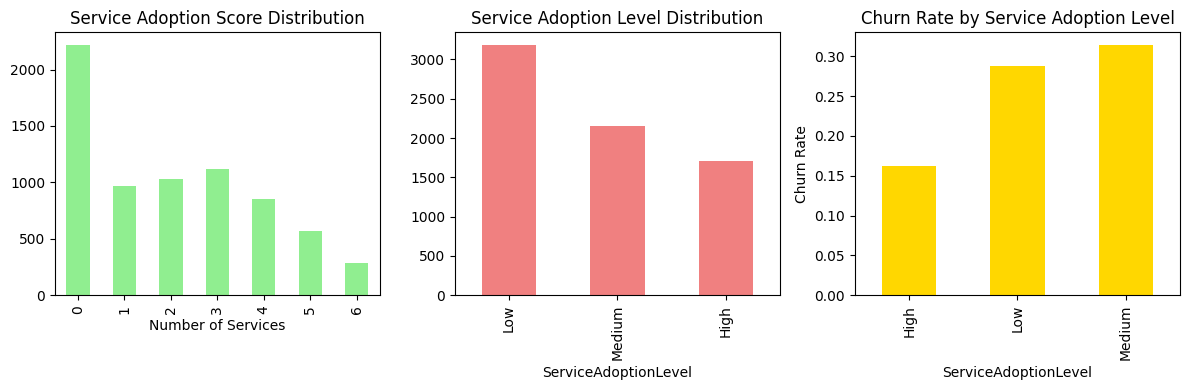

Service Adoption Score Summary:
ServiceAdoptionScore
0    2219
1     966
2    1033
3    1118
4     852
5     571
6     284
Name: count, dtype: int64


In [31]:
def create_service_adoption_score(df):
    """Create a service adoption score based on additional services"""
    df = df.copy()
    
    # List of service columns (excluding core services)
    service_cols = [
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
        'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    
    # Create binary indicators for each service (1 if 'Yes', 0 otherwise)
    for col in service_cols:
        df[f'{col}_Binary'] = (df[col] == 'Yes').astype(int)
    
    # Calculate service adoption score (0-6)
    binary_cols = [f'{col}_Binary' for col in service_cols]
    df['ServiceAdoptionScore'] = df[binary_cols].sum(axis=1)
    
    # Create categorical version
    def categorize_service_adoption(score):
        if score <= 1:
            return 'Low'
        elif score <= 3:
            return 'Medium'
        else:
            return 'High'
    
    df['ServiceAdoptionLevel'] = df['ServiceAdoptionScore'].apply(categorize_service_adoption)
    
    return df

df_engineered = create_service_adoption_score(df_engineered)

# Visualize service adoption
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
df_engineered['ServiceAdoptionScore'].value_counts().sort_index().plot(kind='bar', color='lightgreen')
plt.title('Service Adoption Score Distribution')
plt.xlabel('Number of Services')

plt.subplot(1, 3, 2)
df_engineered['ServiceAdoptionLevel'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Service Adoption Level Distribution')

plt.subplot(1, 3, 3)
adoption_churn = df_engineered.groupby('ServiceAdoptionLevel')['Churn'].apply(lambda x: (x=='Yes').mean())
adoption_churn.plot(kind='bar', color='gold')
plt.title('Churn Rate by Service Adoption Level')
plt.ylabel('Churn Rate')

plt.tight_layout()
plt.show()

print("Service Adoption Score Summary:")
print(df_engineered['ServiceAdoptionScore'].value_counts().sort_index())

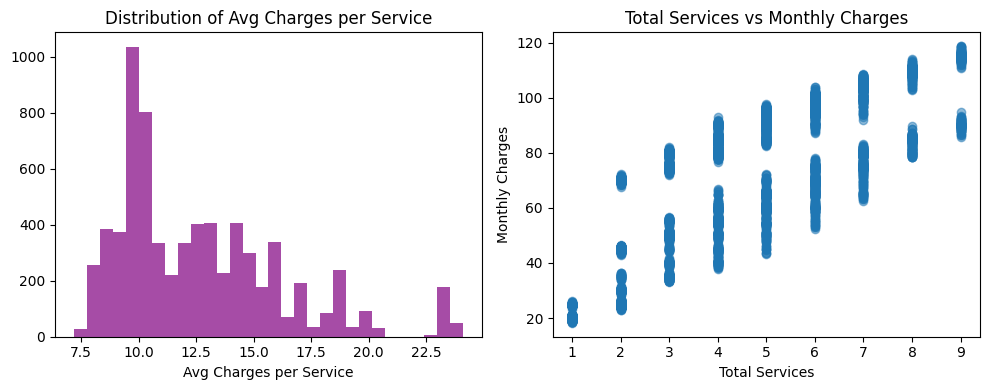

Average Charges per Service Summary:
count    7043.000000
mean       12.639055
std         3.598858
min         7.208333
25%         9.900000
50%        11.933333
75%        14.733333
max        24.083333
Name: AvgChargesPerService, dtype: float64


In [32]:
def create_avg_charges_per_service(df):
    """Create average monthly charges per service indicator"""
    df = df.copy()
    
    # Calculate number of services (including base service)
    service_cols = [
        'PhoneService', 'MultipleLines', 'InternetService',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
        'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    
    # Count active services
    service_count = 0
    for col in service_cols:
        if col == 'InternetService':
            service_count += (df[col] != 'No').astype(int)
        elif col == 'MultipleLines':
            service_count += (df[col] == 'Yes').astype(int)
        elif col == 'PhoneService':
            service_count += (df[col] == 'Yes').astype(int)
        else:
            service_count += (df[col] == 'Yes').astype(int)
    
    df['TotalServices'] = service_count
    
    # Calculate average monthly charge per service
    df['AvgChargesPerService'] = df['MonthlyCharges'] / (df['TotalServices'] + 1)  # +1 to avoid division by 0
    
    return df

df_engineered = create_avg_charges_per_service(df_engineered)

# Visualize average charges per service
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(df_engineered['AvgChargesPerService'], bins=30, alpha=0.7, color='purple')
plt.title('Distribution of Avg Charges per Service')
plt.xlabel('Avg Charges per Service')

plt.subplot(1, 2, 2)
plt.scatter(df_engineered['TotalServices'], df_engineered['MonthlyCharges'], alpha=0.5)
plt.title('Total Services vs Monthly Charges')
plt.xlabel('Total Services')
plt.ylabel('Monthly Charges')

plt.tight_layout()
plt.show()

print("Average Charges per Service Summary:")
print(df_engineered['AvgChargesPerService'].describe())

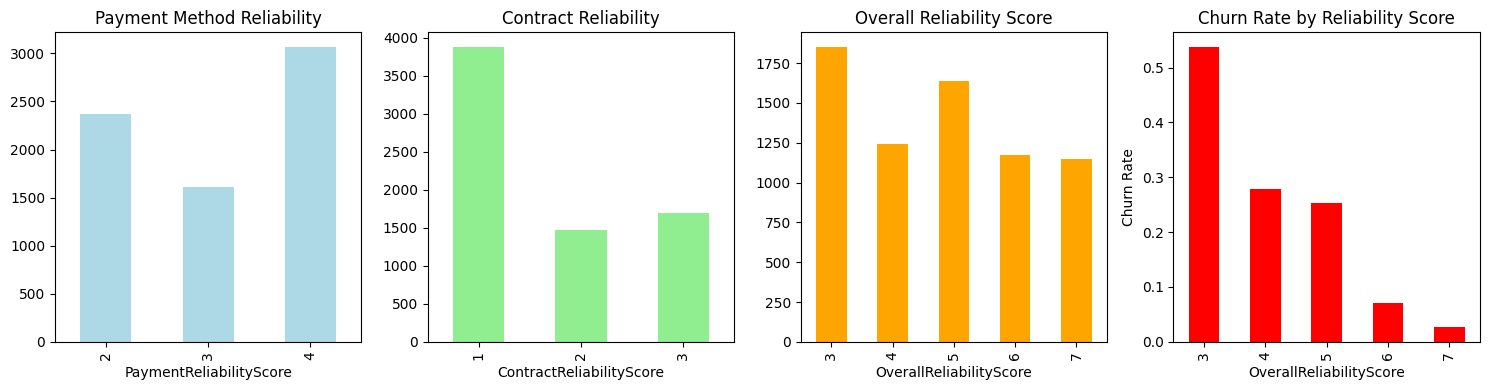

Payment Reliability Summary:
Payment Method Reliability Scores:
PaymentMethod
Bank transfer (automatic)    4
Credit card (automatic)      4
Electronic check             2
Mailed check                 3
Name: PaymentReliabilityScore, dtype: int64


In [34]:
def create_payment_reliability_indicators(df):
    """Create payment reliability indicators"""
    df = df.copy()
    
    # Payment method reliability score (based on typical reliability)
    payment_reliability = {
        'Bank transfer (automatic)': 4,
        'Credit card (automatic)': 4,
        'Electronic check': 2,
        'Mailed check': 3
    }
    
    df['PaymentReliabilityScore'] = df['PaymentMethod'].map(payment_reliability)
    
    # Contract reliability (longer contracts are more reliable)
    contract_reliability = {
        'Month-to-month': 1,
        'One year': 2,
        'Two year': 3
    }
    
    df['ContractReliabilityScore'] = df['Contract'].map(contract_reliability)
    
    # Combined reliability score
    df['OverallReliabilityScore'] = df['PaymentReliabilityScore'] + df['ContractReliabilityScore']
    
    # Paperless billing indicator (might indicate tech-savviness)
    df['PaperlessBilling_Binary'] = (df['PaperlessBilling'] == 'Yes').astype(int)
    
    return df

df_engineered = create_payment_reliability_indicators(df_engineered)

# Visualize payment reliability
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
df_engineered['PaymentReliabilityScore'].value_counts().sort_index().plot(kind='bar', color='lightblue')
plt.title('Payment Method Reliability')

plt.subplot(1, 4, 2)
df_engineered['ContractReliabilityScore'].value_counts().sort_index().plot(kind='bar', color='lightgreen')
plt.title('Contract Reliability')

plt.subplot(1, 4, 3)
df_engineered['OverallReliabilityScore'].value_counts().sort_index().plot(kind='bar', color='orange')
plt.title('Overall Reliability Score')

plt.subplot(1, 4, 4)
reliability_churn = df_engineered.groupby('OverallReliabilityScore')['Churn'].apply(lambda x: (x=='Yes').mean())
reliability_churn.plot(kind='bar', color='red')
plt.title('Churn Rate by Reliability Score')
plt.ylabel('Churn Rate')

plt.tight_layout()
plt.show()

print("Payment Reliability Summary:")
print("Payment Method Reliability Scores:")
print(df_engineered.groupby('PaymentMethod')['PaymentReliabilityScore'].first())

In [35]:
# Separate different types of variables
def categorize_variables(df):
    """Categorize variables into different types"""
    
    # Exclude engineered binary columns and customerID
    exclude_cols = [col for col in df.columns if col.endswith('_Binary')] + ['customerID']
    
    binary_categorical = []
    multi_categorical = []
    ordinal_categorical = []
    numerical = []
    
    for col in df.columns:
        if col in exclude_cols:
            continue
            
        if df[col].dtype in ['int64', 'float64']:
            numerical.append(col)
        elif df[col].dtype == 'object':
            unique_vals = df[col].unique()
            if len(unique_vals) == 2:
                binary_categorical.append(col)
            elif col in ['TenureCategory', 'ServiceAdoptionLevel']:  # Ordinal
                ordinal_categorical.append(col)
            else:
                multi_categorical.append(col)
    
    return {
        'binary_categorical': binary_categorical,
        'multi_categorical': multi_categorical, 
        'ordinal_categorical': ordinal_categorical,
        'numerical': numerical
    }

var_types = categorize_variables(df_engineered)

print("Variable Types:")
for var_type, cols in var_types.items():
    print(f"{var_type}: {cols}")

Variable Types:
binary_categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
multi_categorical: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
ordinal_categorical: ['TenureCategory', 'ServiceAdoptionLevel']
numerical: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'ServiceAdoptionScore', 'TotalServices', 'AvgChargesPerService', 'PaymentReliabilityScore', 'ContractReliabilityScore', 'OverallReliabilityScore']


In [36]:
def apply_label_encoding(df, categorical_cols):
    """Apply label encoding to categorical variables"""
    df_encoded = df.copy()
    
    encoders = {}
    for col in categorical_cols:
        if col in df_encoded.columns:
            le = LabelEncoder()
            df_encoded[f'{col}_LabelEncoded'] = le.fit_transform(df_encoded[col])
            encoders[col] = le
    
    return df_encoded, encoders

def apply_onehot_encoding(df, categorical_cols):
    """Apply one-hot encoding to categorical variables"""
    df_encoded = df.copy()
    
    for col in categorical_cols:
        if col in df_encoded.columns and len(df[col].unique()) <= 5:  # Only for columns with ≤5 categories
            dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True)
            df_encoded = pd.concat([df_encoded, dummies], axis=1)
    
    return df_encoded

def apply_ordinal_encoding(df, ordinal_mappings):
    """Apply ordinal encoding with specified mappings"""
    df_encoded = df.copy()
    
    for col, mapping in ordinal_mappings.items():
        if col in df_encoded.columns:
            df_encoded[f'{col}_OrdinalEncoded'] = df_encoded[col].map(mapping)
    
    return df_encoded

# Define ordinal mappings
ordinal_mappings = {
    'TenureCategory': {'New': 0, 'Established': 1, 'Loyal': 2},
    'ServiceAdoptionLevel': {'Low': 0, 'Medium': 1, 'High': 2}
}

# Apply different encoding methods
print("Applying different encoding methods...")

# Label Encoding
df_label_encoded, label_encoders = apply_label_encoding(df_engineered, var_types['binary_categorical'] + var_types['multi_categorical'])

# One-Hot Encoding
df_onehot_encoded = apply_onehot_encoding(df_engineered, var_types['binary_categorical'] + var_types['multi_categorical'])

# Ordinal Encoding
df_ordinal_encoded = apply_ordinal_encoding(df_engineered, ordinal_mappings)

print("Encoding completed!")
print(f"Original columns: {len(df_engineered.columns)}")
print(f"After Label Encoding: {len(df_label_encoded.columns)}")
print(f"After One-Hot Encoding: {len(df_onehot_encoded.columns)}")
print(f"After Ordinal Encoding: {len(df_ordinal_encoded.columns)}")

Applying different encoding methods...
Encoding completed!
Original columns: 36
After Label Encoding: 52
After One-Hot Encoding: 63
After Ordinal Encoding: 38


In [37]:
def create_final_encoded_dataset(df):
    """Create the final encoded dataset combining all encoding strategies"""
    df_final = df.copy()
    
    # Binary encoding for Yes/No variables
    binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
    for col in binary_cols:
        df_final[f'{col}_Encoded'] = (df_final[col] == 'Yes').astype(int)
    
    # Ordinal encoding for ordered categories
    ordinal_mappings = {
        'TenureCategory': {'New': 0, 'Established': 1, 'Loyal': 2},
        'ServiceAdoptionLevel': {'Low': 0, 'Medium': 1, 'High': 2}
    }
    
    for col, mapping in ordinal_mappings.items():
        df_final[f'{col}_Encoded'] = df_final[col].map(mapping)
    
    # One-hot encoding for nominal categorical variables
    nominal_cols = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                   'StreamingMovies', 'Contract', 'PaymentMethod']
    
    for col in nominal_cols:
        if col in df_final.columns:
            dummies = pd.get_dummies(df_final[col], prefix=col, drop_first=True)
            df_final = pd.concat([df_final, dummies], axis=1)
    
    return df_final

df_final_encoded = create_final_encoded_dataset(df_engineered)

print("Final encoded dataset shape:", df_final_encoded.shape)
print("\nNew encoded columns:")
encoded_cols = [col for col in df_final_encoded.columns if ('_Encoded' in col) or any(cat in col for cat in ['gender_', 'MultipleLines_', 'InternetService_', 'Contract_', 'PaymentMethod_'])]
print(encoded_cols)

Final encoded dataset shape: (7043, 65)

New encoded columns:
['Partner_Encoded', 'Dependents_Encoded', 'PhoneService_Encoded', 'PaperlessBilling_Encoded', 'Churn_Encoded', 'TenureCategory_Encoded', 'ServiceAdoptionLevel_Encoded', 'gender_Male', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


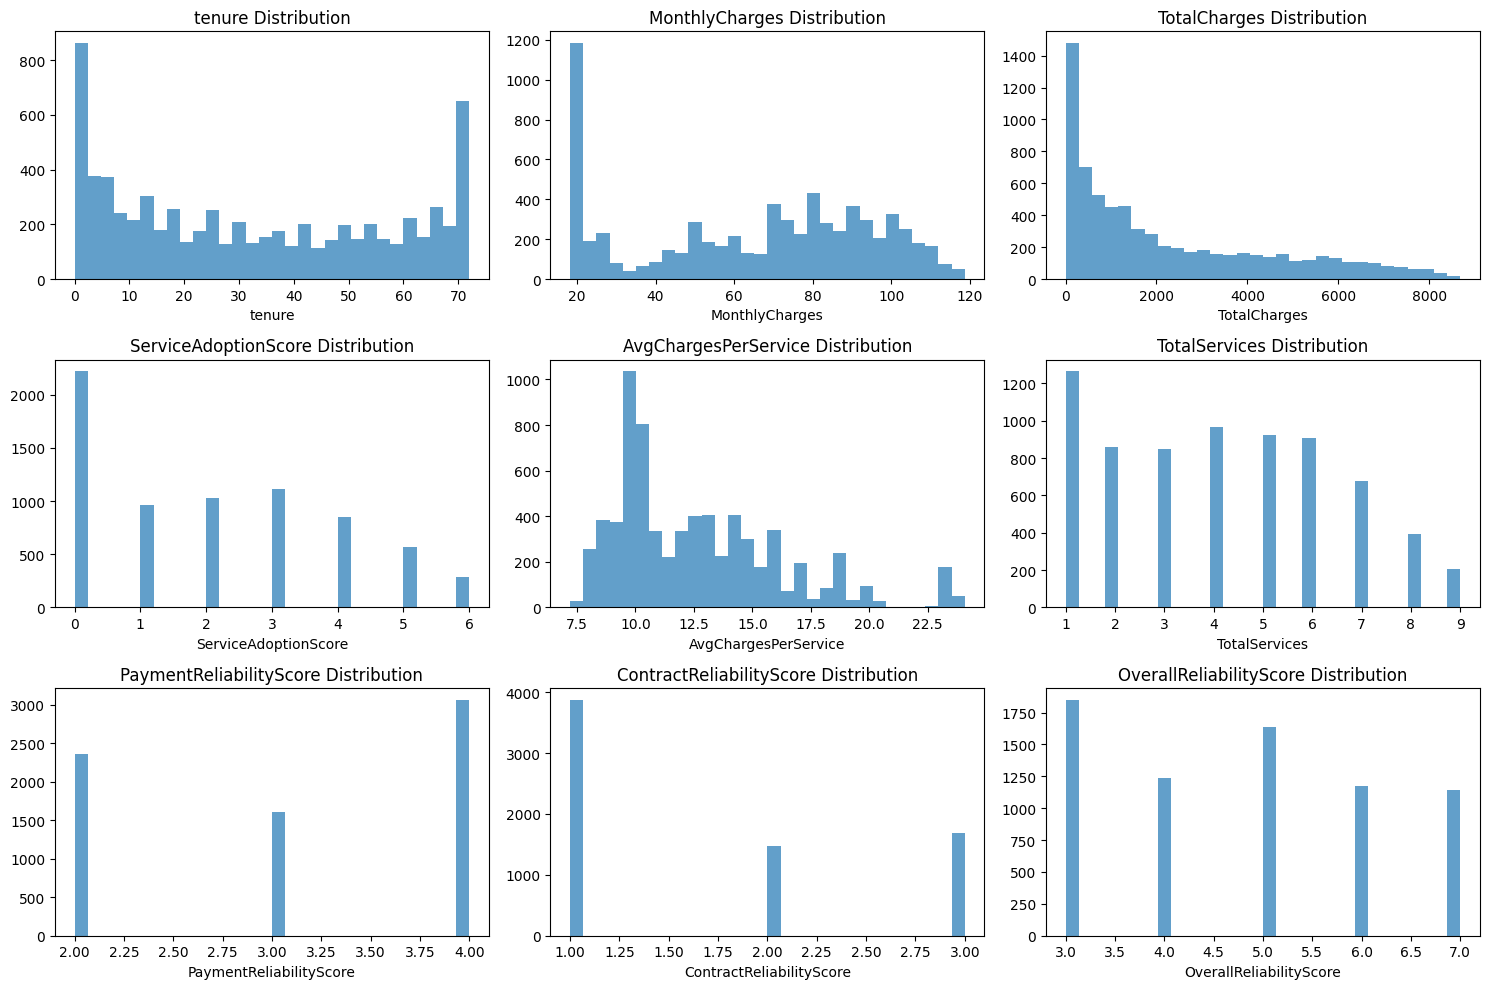

Numerical Features Summary (Before Scaling):
            tenure  MonthlyCharges  TotalCharges  ServiceAdoptionScore  \
count  7043.000000     7043.000000   7043.000000           7043.000000   
mean     32.371149       64.761692   2279.734304              2.037910   
std      24.559481       30.090047   2266.794470              1.847682   
min       0.000000       18.250000      0.000000              0.000000   
25%       9.000000       35.500000    398.550000              0.000000   
50%      29.000000       70.350000   1394.550000              2.000000   
75%      55.000000       89.850000   3786.600000              3.000000   
max      72.000000      118.750000   8684.800000              6.000000   

       AvgChargesPerService  TotalServices  PaymentReliabilityScore  \
count           7043.000000    7043.000000              7043.000000   
mean              12.639055       4.146244                 3.099531   
std                3.598858       2.312720                 0.872538   
min 

In [38]:
# Select numerical features for scaling
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'ServiceAdoptionScore', 
                     'AvgChargesPerService', 'TotalServices', 'PaymentReliabilityScore', 
                     'ContractReliabilityScore', 'OverallReliabilityScore']

# Check distributions before scaling
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    plt.hist(df_final_encoded[col], bins=30, alpha=0.7)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

print("Numerical Features Summary (Before Scaling):")
print(df_final_encoded[numerical_features].describe())

In [39]:
def apply_scaling_methods(df, numerical_cols):
    """Apply different scaling methods to numerical features"""
    df_scaled = df.copy()
    
    # Standard Scaling (Z-score normalization)
    scaler_standard = StandardScaler()
    df_scaled[[f'{col}_StandardScaled' for col in numerical_cols]] = scaler_standard.fit_transform(df[numerical_cols])
    
    # Min-Max Scaling
    scaler_minmax = MinMaxScaler()
    df_scaled[[f'{col}_MinMaxScaled' for col in numerical_cols]] = scaler_minmax.fit_transform(df[numerical_cols])
    
    return df_scaled, {'standard': scaler_standard, 'minmax': scaler_minmax}

df_scaled, scalers = apply_scaling_methods(df_final_encoded, numerical_features)

print("Scaling completed!")
print(f"Dataset shape after scaling: {df_scaled.shape}")

# Compare scaling methods
print("\nComparison of Scaling Methods (first 3 features):")
comparison_cols = numerical_features[:3]
for col in comparison_cols:
    print(f"\n{col}:")
    print(f"Original: mean={df_final_encoded[col].mean():.2f}, std={df_final_encoded[col].std():.2f}")
    print(f"Standard Scaled: mean={df_scaled[f'{col}_StandardScaled'].mean():.2f}, std={df_scaled[f'{col}_StandardScaled'].std():.2f}")
    print(f"MinMax Scaled: min={df_scaled[f'{col}_MinMaxScaled'].min():.2f}, max={df_scaled[f'{col}_MinMaxScaled'].max():.2f}")

Scaling completed!
Dataset shape after scaling: (7043, 83)

Comparison of Scaling Methods (first 3 features):

tenure:
Original: mean=32.37, std=24.56
Standard Scaled: mean=-0.00, std=1.00
MinMax Scaled: min=0.00, max=1.00

MonthlyCharges:
Original: mean=64.76, std=30.09
Standard Scaled: mean=-0.00, std=1.00
MinMax Scaled: min=0.00, max=1.00

TotalCharges:
Original: mean=2279.73, std=2266.79
Standard Scaled: mean=-0.00, std=1.00
MinMax Scaled: min=0.00, max=1.00


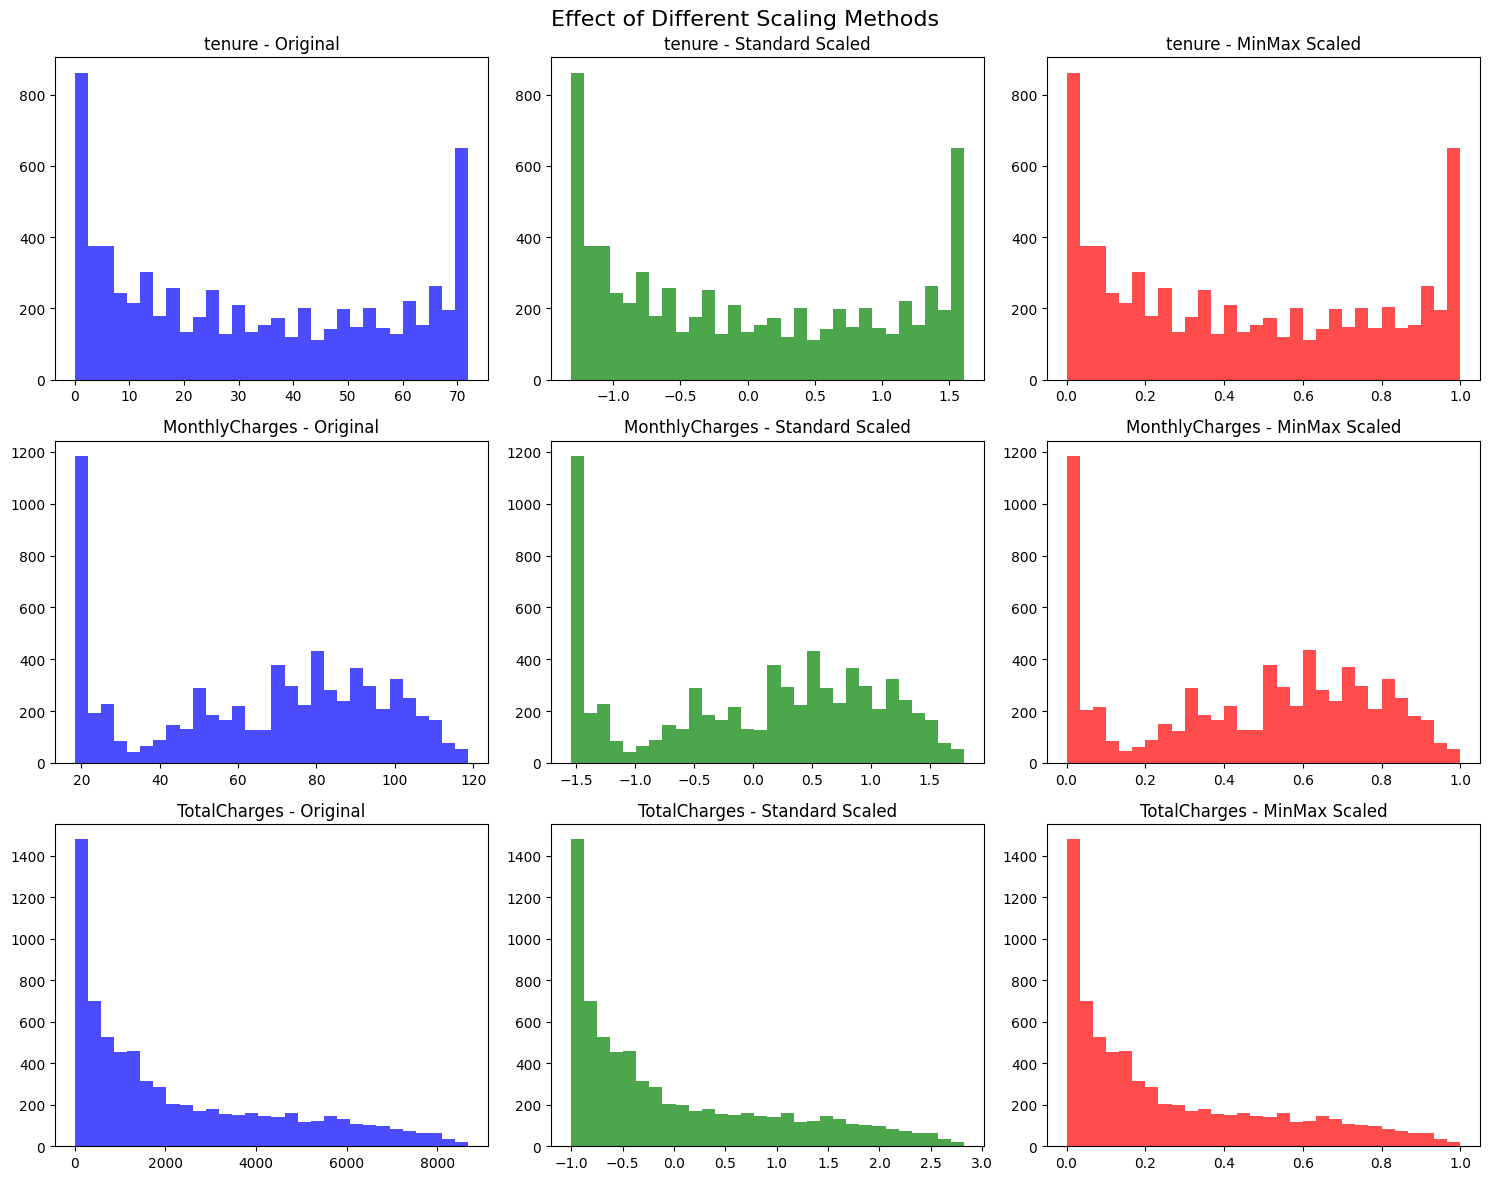

In [40]:
# Visualize the effect of scaling
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Effect of Different Scaling Methods', fontsize=16)

for i, col in enumerate(comparison_cols):
    # Original distribution
    axes[i, 0].hist(df_final_encoded[col], bins=30, alpha=0.7, color='blue')
    axes[i, 0].set_title(f'{col} - Original')
    
    # Standard scaled distribution
    axes[i, 1].hist(df_scaled[f'{col}_StandardScaled'], bins=30, alpha=0.7, color='green')
    axes[i, 1].set_title(f'{col} - Standard Scaled')
    
    # Min-Max scaled distribution
    axes[i, 2].hist(df_scaled[f'{col}_MinMaxScaled'], bins=30, alpha=0.7, color='red')
    axes[i, 2].set_title(f'{col} - MinMax Scaled')

plt.tight_layout()
plt.show()

In [41]:
def create_modeling_dataset(df):
    """Create final clean dataset for modeling"""
    
    # Select relevant columns for modeling
    feature_cols = []
    
    # Encoded categorical features
    encoded_categorical = [col for col in df.columns if '_Encoded' in col and col != 'Churn_Encoded']
    feature_cols.extend(encoded_categorical)
    
    # One-hot encoded features
    onehot_cols = [col for col in df.columns if any(cat in col for cat in 
                  ['gender_', 'MultipleLines_', 'InternetService_', 'OnlineSecurity_', 
                   'OnlineBackup_', 'DeviceProtection_', 'TechSupport_', 'StreamingTV_', 
                   'StreamingMovies_', 'Contract_', 'PaymentMethod_'])]
    feature_cols.extend(onehot_cols)
    
    # Scaled numerical features (using Standard Scaling)
    scaled_numerical = [f'{col}_StandardScaled' for col in numerical_features]
    feature_cols.extend(scaled_numerical)
    
    # Create modeling dataset
    X = df[feature_cols]
    y = df['Churn_Encoded']
    
    return X, y, feature_cols

X, y, feature_columns = create_modeling_dataset(df_scaled)

print("Final Modeling Dataset:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {len(feature_columns)}")

print(f"\nTarget distribution:")
print(y.value_counts())
print(f"Churn rate: {y.mean():.2%}")

Final Modeling Dataset:
Features shape: (7043, 43)
Target shape: (7043,)
Number of features: 43

Target distribution:
Churn_Encoded
0    5174
1    1869
Name: count, dtype: int64
Churn rate: 26.54%


In [42]:
# Create a comprehensive data dictionary
def create_data_dictionary():
    """Create a data dictionary for all features"""
    
    data_dict = {
        'Original Features': [
            'customerID - Unique customer identifier',
            'gender - Customer gender (Male/Female)', 
            'SeniorCitizen - Whether customer is senior citizen (0/1)',
            'Partner - Whether customer has partner (Yes/No)',
            'Dependents - Whether customer has dependents (Yes/No)',
            'tenure - Number of months customer has stayed',
            'PhoneService - Whether customer has phone service (Yes/No)',
            'MultipleLines - Whether customer has multiple lines',
            'InternetService - Type of internet service',
            'OnlineSecurity - Whether customer has online security',
            'OnlineBackup - Whether customer has online backup',
            'DeviceProtection - Whether customer has device protection',
            'TechSupport - Whether customer has tech support',
            'StreamingTV - Whether customer has streaming TV',
            'StreamingMovies - Whether customer has streaming movies',
            'Contract - Contract type (Month-to-month, One year, Two year)',
            'PaperlessBilling - Whether customer uses paperless billing',
            'PaymentMethod - Payment method',
            'MonthlyCharges - Monthly charges amount',
            'TotalCharges - Total charges amount',
            'Churn - Whether customer churned (Yes/No)'
        ],
        'Engineered Features': [
            'TenureCategory - Categorized tenure (New/Established/Loyal)',
            'ServiceAdoptionScore - Number of additional services (0-6)',
            'ServiceAdoptionLevel - Service adoption level (Low/Medium/High)',
            'AvgChargesPerService - Average monthly charges per service',
            'TotalServices - Total number of services',
            'PaymentReliabilityScore - Payment method reliability score (2-4)',
            'ContractReliabilityScore - Contract reliability score (1-3)',
            'OverallReliabilityScore - Combined reliability score (3-7)'
        ],
        'Encoded Features': [
            '*_Encoded - Binary encoded categorical features',
            '*_StandardScaled - Standard scaled numerical features',
            'One-hot encoded categorical features with prefixes'
        ]
    }
    
    return data_dict

data_dict = create_data_dictionary()

print("DATA DICTIONARY")
print("=" * 50)
for category, features in data_dict.items():
    print(f"\n{category}:")
    print("-" * len(category))
    for feature in features:
        print(f"  • {feature}")

DATA DICTIONARY

Original Features:
-----------------
  • customerID - Unique customer identifier
  • gender - Customer gender (Male/Female)
  • SeniorCitizen - Whether customer is senior citizen (0/1)
  • Partner - Whether customer has partner (Yes/No)
  • Dependents - Whether customer has dependents (Yes/No)
  • tenure - Number of months customer has stayed
  • PhoneService - Whether customer has phone service (Yes/No)
  • MultipleLines - Whether customer has multiple lines
  • InternetService - Type of internet service
  • OnlineSecurity - Whether customer has online security
  • OnlineBackup - Whether customer has online backup
  • DeviceProtection - Whether customer has device protection
  • TechSupport - Whether customer has tech support
  • StreamingTV - Whether customer has streaming TV
  • StreamingMovies - Whether customer has streaming movies
  • Contract - Contract type (Month-to-month, One year, Two year)
  • PaperlessBilling - Whether customer uses paperless billing
  • P

In [43]:
# Save the preprocessed dataset
def export_datasets(df_original, df_processed, X, y):
    """Export datasets for future use"""
    
    # Save preprocessed full dataset
    df_processed.to_csv('telco_preprocessed_full.csv', index=False)
    
    # Save modeling dataset
    modeling_df = X.copy()
    modeling_df['Churn'] = y
    modeling_df.to_csv('telco_modeling_dataset.csv', index=False)
    
    # Save feature names
    with open('feature_names.txt', 'w') as f:
        f.write("Feature Names for Modeling:\n")
        f.write("=" * 30 + "\n")
        for i, feature in enumerate(X.columns, 1):
            f.write(f"{i:2d}. {feature}\n")
    
    print("Datasets exported successfully!")
    print("Files created:")
    print("  • telco_preprocessed_full.csv - Full preprocessed dataset")
    print("  • telco_modeling_dataset.csv - Clean dataset for modeling")
    print("  • feature_names.txt - List of feature names")

# Export datasets
export_datasets(df, df_scaled, X, y)

print(f"\nPreprocessing Pipeline Complete!")
print(f"Original dataset: {df.shape}")
print(f"Final modeling dataset: {X.shape}")
print(f"Ready for machine learning!")

Datasets exported successfully!
Files created:
  • telco_preprocessed_full.csv - Full preprocessed dataset
  • telco_modeling_dataset.csv - Clean dataset for modeling
  • feature_names.txt - List of feature names

Preprocessing Pipeline Complete!
Original dataset: (7043, 21)
Final modeling dataset: (7043, 43)
Ready for machine learning!


In [44]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter
import matplotlib.pyplot as plt

# Initial train-test split (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Dataset Split Summary:")
print("=" * 40)
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

print(f"\nClass distribution in original dataset:")
print(f"Class 0 (No Churn): {(y == 0).sum()} ({(y == 0).mean():.1%})")
print(f"Class 1 (Churn): {(y == 1).sum()} ({(y == 1).mean():.1%})")

print(f"\nClass distribution in training set:")
print(f"Class 0 (No Churn): {(y_train == 0).sum()} ({(y_train == 0).mean():.1%})")
print(f"Class 1 (Churn): {(y_train == 1).sum()} ({(y_train == 1).mean():.1%})")

print(f"\nClass distribution in test set:")
print(f"Class 0 (No Churn): {(y_test == 0).sum()} ({(y_test == 0).mean():.1%})")
print(f"Class 1 (Churn): {(y_test == 1).sum()} ({(y_test == 1).mean():.1%})")

Dataset Split Summary:
Training set: (5634, 43)
Test set: (1409, 43)

Class distribution in original dataset:
Class 0 (No Churn): 5174 (73.5%)
Class 1 (Churn): 1869 (26.5%)

Class distribution in training set:
Class 0 (No Churn): 4139 (73.5%)
Class 1 (Churn): 1495 (26.5%)

Class distribution in test set:
Class 0 (No Churn): 1035 (73.5%)
Class 1 (Churn): 374 (26.5%)


Class Imbalance Analysis:
Training set imbalance ratio: 2.77:1
Test set imbalance ratio: 2.77:1


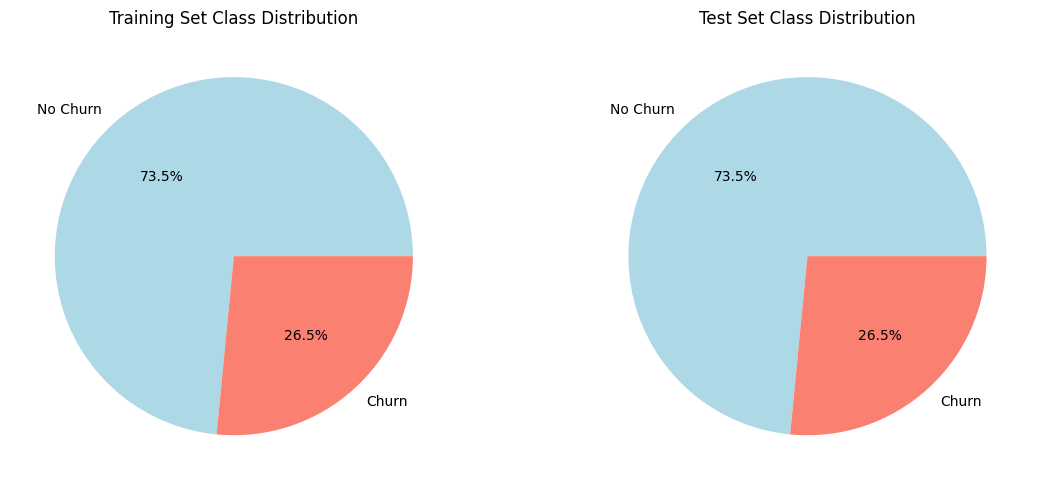


⚠️  Class imbalance detected (ratio: 2.77:1)
Recommendation: Apply rebalancing techniques


In [45]:
def analyze_class_imbalance(y_train, y_test):
    """Analyze the extent of class imbalance"""
    
    # Calculate imbalance metrics
    train_counts = Counter(y_train)
    test_counts = Counter(y_test)
    
    # Imbalance ratio
    train_imbalance_ratio = train_counts[0] / train_counts[1]
    test_imbalance_ratio = test_counts[0] / test_counts[1]
    
    print("Class Imbalance Analysis:")
    print("=" * 50)
    print(f"Training set imbalance ratio: {train_imbalance_ratio:.2f}:1")
    print(f"Test set imbalance ratio: {test_imbalance_ratio:.2f}:1")
    
    # Visualize class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Training set distribution
    train_labels = ['No Churn', 'Churn']
    train_values = [train_counts[0], train_counts[1]]
    colors = ['lightblue', 'salmon']
    
    ax1.pie(train_values, labels=train_labels, autopct='%1.1f%%', colors=colors)
    ax1.set_title('Training Set Class Distribution')
    
    # Test set distribution
    test_values = [test_counts[0], test_counts[1]]
    ax2.pie(test_values, labels=train_labels, autopct='%1.1f%%', colors=colors)
    ax2.set_title('Test Set Class Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return train_imbalance_ratio

imbalance_ratio = analyze_class_imbalance(y_train, y_test)

# Determine if rebalancing is needed
if imbalance_ratio > 1.5:
    print(f"\n⚠️  Class imbalance detected (ratio: {imbalance_ratio:.2f}:1)")
    print("Recommendation: Apply rebalancing techniques")
else:
    print(f"\n✅ Class distribution is relatively balanced (ratio: {imbalance_ratio:.2f}:1)")

In [46]:
def apply_rebalancing_techniques(X_train, y_train):
    """Apply different rebalancing techniques and compare results"""
    
    rebalanced_datasets = {}
    
    print("Applying Rebalancing Techniques...")
    print("=" * 50)
    
    # 1. Random Over-sampling
    print("1. Random Over-sampling...")
    ros = RandomOverSampler(random_state=42)
    X_ros, y_ros = ros.fit_resample(X_train, y_train)
    rebalanced_datasets['Random Over-sampling'] = (X_ros, y_ros)
    
    # 2. SMOTE (Synthetic Minority Over-sampling)
    print("2. SMOTE...")
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    rebalanced_datasets['SMOTE'] = (X_smote, y_smote)
    
    # 3. ADASYN (Adaptive Synthetic Sampling)
    print("3. ADASYN...")
    adasyn = ADASYN(random_state=42)
    X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
    rebalanced_datasets['ADASYN'] = (X_adasyn, y_adasyn)
    
    # 4. Random Under-sampling
    print("4. Random Under-sampling...")
    rus = RandomUnderSampler(random_state=42)
    X_rus, y_rus = rus.fit_resample(X_train, y_train)
    rebalanced_datasets['Random Under-sampling'] = (X_rus, y_rus)
    
    # 5. Tomek Links (Under-sampling)
    print("5. Tomek Links...")
    tomek = TomekLinks()
    X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)
    rebalanced_datasets['Tomek Links'] = (X_tomek, y_tomek)
    
    # 6. SMOTE + ENN (Combined)
    print("6. SMOTE + ENN...")
    smoteenn = SMOTEENN(random_state=42)
    X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, y_train)
    rebalanced_datasets['SMOTE + ENN'] = (X_smoteenn, y_smoteenn)
    
    # 7. SMOTE + Tomek (Combined)
    print("7. SMOTE + Tomek...")
    smotetomek = SMOTETomek(random_state=42)
    X_smotetomek, y_smotetomek = smotetomek.fit_resample(X_train, y_train)
    rebalanced_datasets['SMOTE + Tomek'] = (X_smotetomek, y_smotetomek)
    
    return rebalanced_datasets

# Apply rebalancing techniques
rebalanced_data = apply_rebalancing_techniques(X_train, y_train)

print("✅ Rebalancing techniques applied successfully!")

Applying Rebalancing Techniques...
1. Random Over-sampling...
2. SMOTE...
3. ADASYN...
4. Random Under-sampling...
5. Tomek Links...
6. SMOTE + ENN...
7. SMOTE + Tomek...
✅ Rebalancing techniques applied successfully!


Rebalancing Techniques Comparison:
            Technique  Total_Samples  No_Churn  Churn Imbalance_Ratio
             Original           5634      4139   1495          2.77:1
 Random Over-sampling           8278      4139   4139          1.00:1
                SMOTE           8278      4139   4139          1.00:1
               ADASYN           8216      4139   4077          1.02:1
Random Under-sampling           2990      1495   1495          1.00:1
          Tomek Links           5245      3750   1495          2.51:1
          SMOTE + ENN           5246      2298   2948          0.78:1
        SMOTE + Tomek           7946      3973   3973          1.00:1


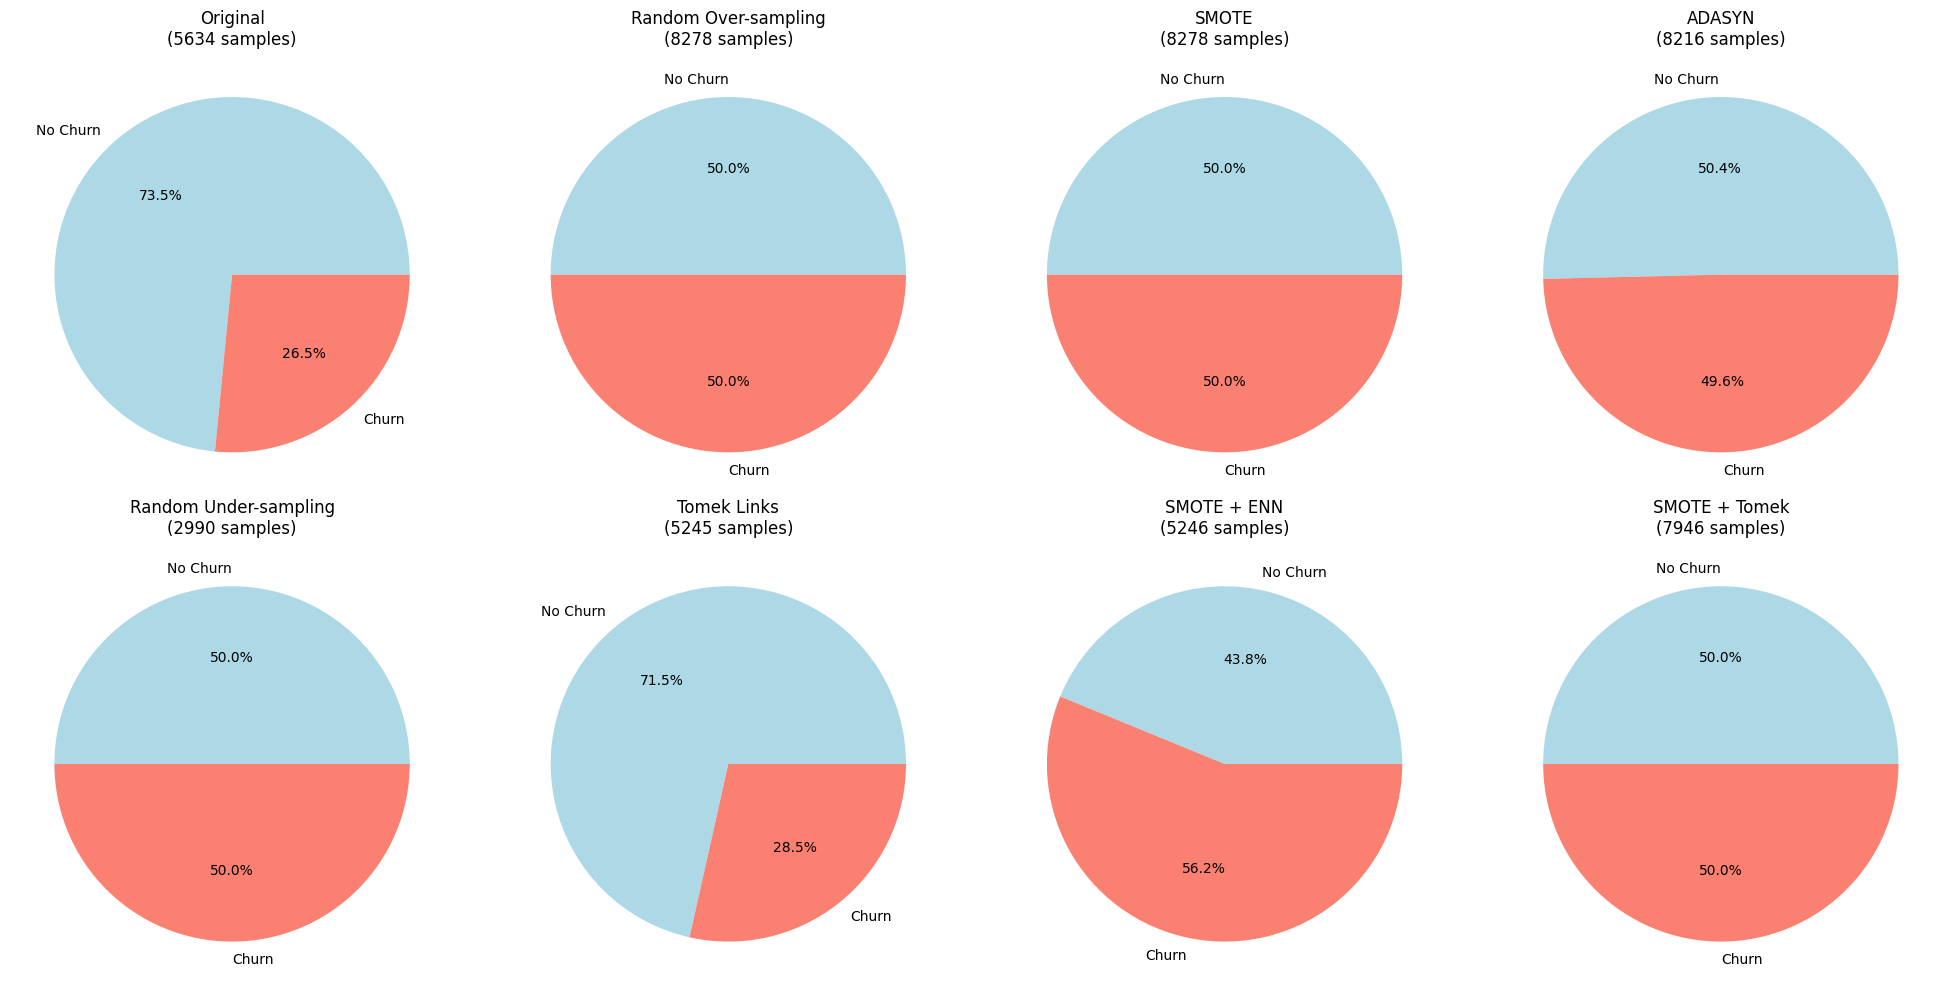

In [47]:
def compare_rebalancing_results(original_data, rebalanced_datasets, y_test):
    """Compare the results of different rebalancing techniques"""
    
    # Prepare comparison data
    X_train_orig, y_train_orig = original_data
    
    techniques = ['Original'] + list(rebalanced_datasets.keys())
    sample_counts = []
    class_distributions = []
    
    # Original data
    orig_counts = Counter(y_train_orig)
    sample_counts.append(len(y_train_orig))
    class_distributions.append({
        'No Churn': orig_counts[0],
        'Churn': orig_counts[1],
        'Ratio': orig_counts[0] / orig_counts[1]
    })
    
    # Rebalanced data
    for technique, (X_resampled, y_resampled) in rebalanced_datasets.items():
        counts = Counter(y_resampled)
        sample_counts.append(len(y_resampled))
        class_distributions.append({
            'No Churn': counts[0],
            'Churn': counts[1],
            'Ratio': counts[0] / counts[1] if counts[1] > 0 else float('inf')
        })
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Technique': techniques,
        'Total_Samples': sample_counts,
        'No_Churn': [d['No Churn'] for d in class_distributions],
        'Churn': [d['Churn'] for d in class_distributions],
        'Imbalance_Ratio': [f"{d['Ratio']:.2f}:1" for d in class_distributions]
    })
    
    print("Rebalancing Techniques Comparison:")
    print("=" * 70)
    print(comparison_df.to_string(index=False))
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    colors = ['lightblue', 'salmon']
    
    for i, (technique, (X_res, y_res)) in enumerate([('Original', (X_train_orig, y_train_orig))] + list(rebalanced_datasets.items())):
        counts = Counter(y_res)
        labels = ['No Churn', 'Churn']
        sizes = [counts[0], counts[1]]
        
        axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
        axes[i].set_title(f'{technique}\n({len(y_res)} samples)')
    
    # Hide unused subplot
    if len(axes) > len(rebalanced_datasets) + 1:
        axes[-1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Compare results
comparison_results = compare_rebalancing_results((X_train, y_train), rebalanced_data, y_test)

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score

def quick_model_evaluation(datasets_dict, X_test, y_test):
    """Quick evaluation of different rebalancing techniques using simple models"""
    
    results = []
    
    # Test with Random Forest and Logistic Regression
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    print("Quick Model Evaluation Results:")
    print("=" * 80)
    
    for technique, (X_train_res, y_train_res) in datasets_dict.items():
        technique_results = {'Technique': technique}
        
        for model_name, model in models.items():
            # Train model
            model.fit(X_train_res, y_train_res)
            
            # Predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Metrics
            auc_score = roc_auc_score(y_test, y_pred_proba)
            
            # Cross-validation score on resampled training data
            cv_scores = cross_val_score(model, X_train_res, y_train_res, cv=3, scoring='roc_auc')
            
            technique_results[f'{model_name}_AUC'] = auc_score
            technique_results[f'{model_name}_CV_AUC'] = cv_scores.mean()
        
        results.append(technique_results)
        
        # Print summary for this technique
        print(f"\n{technique}:")
        print(f"  RF AUC: {technique_results['Random Forest_AUC']:.3f} | CV AUC: {technique_results['Random Forest_CV_AUC']:.3f}")
        print(f"  LR AUC: {technique_results['Logistic Regression_AUC']:.3f} | CV AUC: {technique_results['Logistic Regression_CV_AUC']:.3f}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Add original dataset to comparison
all_datasets = {'Original': (X_train, y_train)}
all_datasets.update(rebalanced_data)

# Evaluate rebalancing techniques
evaluation_results = quick_model_evaluation(all_datasets, X_test, y_test)

print("\n" + "="*80)
print("EVALUATION SUMMARY:")
print("="*80)
print(evaluation_results.round(3))

Quick Model Evaluation Results:

Original:
  RF AUC: 0.817 | CV AUC: 0.821
  LR AUC: 0.841 | CV AUC: 0.846

Random Over-sampling:
  RF AUC: 0.813 | CV AUC: 0.966
  LR AUC: 0.841 | CV AUC: 0.845

SMOTE:
  RF AUC: 0.812 | CV AUC: 0.923
  LR AUC: 0.830 | CV AUC: 0.897

ADASYN:
  RF AUC: 0.813 | CV AUC: 0.903
  LR AUC: 0.827 | CV AUC: 0.883

Random Under-sampling:
  RF AUC: 0.820 | CV AUC: 0.818
  LR AUC: 0.841 | CV AUC: 0.833

Tomek Links:
  RF AUC: 0.818 | CV AUC: 0.864
  LR AUC: 0.840 | CV AUC: 0.869

SMOTE + ENN:
  RF AUC: 0.831 | CV AUC: 0.994
  LR AUC: 0.836 | CV AUC: 0.978

SMOTE + Tomek:
  RF AUC: 0.816 | CV AUC: 0.938
  LR AUC: 0.830 | CV AUC: 0.907

EVALUATION SUMMARY:
               Technique  Random Forest_AUC  Random Forest_CV_AUC  \
0               Original              0.817                 0.821   
1   Random Over-sampling              0.813                 0.966   
2                  SMOTE              0.812                 0.923   
3                 ADASYN              0.

In [49]:
def select_best_rebalancing_method(evaluation_results):
    """Select the best rebalancing method based on evaluation results"""
    
    # Calculate average performance across models
    evaluation_results['Avg_AUC'] = (evaluation_results['Random Forest_AUC'] + 
                                    evaluation_results['Logistic Regression_AUC']) / 2
    
    evaluation_results['Avg_CV_AUC'] = (evaluation_results['Random Forest_CV_AUC'] + 
                                       evaluation_results['Logistic Regression_CV_AUC']) / 2
    
    # Sort by average AUC
    sorted_results = evaluation_results.sort_values('Avg_AUC', ascending=False)
    
    print("Ranking of Rebalancing Techniques:")
    print("=" * 60)
    print(sorted_results[['Technique', 'Avg_AUC', 'Avg_CV_AUC']].round(3))
    
    # Select best method
    best_method = sorted_results.iloc[0]['Technique']
    best_auc = sorted_results.iloc[0]['Avg_AUC']
    
    print(f"\n🏆 RECOMMENDED REBALANCING METHOD: {best_method}")
    print(f"   Average AUC Score: {best_auc:.3f}")
    
    # Additional recommendations based on data size and performance
    print(f"\n📊 RECOMMENDATIONS:")
    
    if best_method == 'Original':
        print("   • The original dataset performs best - no rebalancing needed")
        print("   • Consider using class weights in models instead")
    elif 'SMOTE' in best_method:
        print("   • SMOTE-based methods create synthetic samples")
        print("   • Good for preserving feature relationships")
        print("   • Increases training data size")
    elif 'Under-sampling' in best_method or 'Tomek' in best_method:
        print("   • Under-sampling reduces training data size")
        print("   • Faster training but potential information loss")
        print("   • Good when you have large datasets")
    
    return best_method, sorted_results

best_method, ranked_results = select_best_rebalancing_method(evaluation_results)

Ranking of Rebalancing Techniques:
               Technique  Avg_AUC  Avg_CV_AUC
6            SMOTE + ENN    0.833       0.986
4  Random Under-sampling    0.830       0.825
5            Tomek Links    0.829       0.866
0               Original    0.829       0.834
1   Random Over-sampling    0.827       0.906
7          SMOTE + Tomek    0.823       0.922
2                  SMOTE    0.821       0.910
3                 ADASYN    0.820       0.893

🏆 RECOMMENDED REBALANCING METHOD: SMOTE + ENN
   Average AUC Score: 0.833

📊 RECOMMENDATIONS:
   • SMOTE-based methods create synthetic samples
   • Good for preserving feature relationships
   • Increases training data size


In [50]:
def prepare_final_datasets(best_method, all_datasets, X_test, y_test):
    """Prepare final training and test datasets using the best rebalancing method"""
    
    # Get the best rebalanced training data
    X_train_final, y_train_final = all_datasets[best_method]
    
    print("Final Dataset Preparation:")
    print("=" * 50)
    print(f"Selected Method: {best_method}")
    print(f"Final Training Set: {X_train_final.shape}")
    print(f"Final Test Set: {X_test.shape}")
    
    # Final class distribution
    train_counts = Counter(y_train_final)
    test_counts = Counter(y_test)
    
    print(f"\nFinal Class Distribution:")
    print(f"Training Set - No Churn: {train_counts[0]}, Churn: {train_counts[1]} (Ratio: {train_counts[0]/train_counts[1]:.2f}:1)")
    print(f"Test Set - No Churn: {test_counts[0]}, Churn: {test_counts[1]} (Ratio: {test_counts[0]/test_counts[1]:.2f}:1)")
    
    # Save datasets
    train_df = X_train_final.copy()
    train_df['Churn'] = y_train_final
    train_df.to_csv('telco_train_final.csv', index=False)
    
    test_df = X_test.copy()
    test_df['Churn'] = y_test
    test_df.to_csv('telco_test_final.csv', index=False)
    
    print(f"\n💾 Datasets saved:")
    print("   • telco_train_final.csv - Final training dataset")
    print("   • telco_test_final.csv - Test dataset")
    
    return X_train_final, y_train_final, X_test, y_test

# Prepare final datasets
X_train_final, y_train_final, X_test_final, y_test_final = prepare_final_datasets(
    best_method, all_datasets, X_test, y_test
)

print(f"\n🎯 READY FOR MODELING!")
print(f"   Training samples: {len(X_train_final)}")
print(f"   Test samples: {len(X_test_final)}")
print(f"   Features: {len(X_train_final.columns)}")

Final Dataset Preparation:
Selected Method: SMOTE + ENN
Final Training Set: (5246, 43)
Final Test Set: (1409, 43)

Final Class Distribution:
Training Set - No Churn: 2298, Churn: 2948 (Ratio: 0.78:1)
Test Set - No Churn: 1035, Churn: 374 (Ratio: 2.77:1)

💾 Datasets saved:
   • telco_train_final.csv - Final training dataset
   • telco_test_final.csv - Test dataset

🎯 READY FOR MODELING!
   Training samples: 5246
   Test samples: 1409
   Features: 43


In [51]:
# Dataset Loading Guide - New Optimized vs Old Dataset
import pandas as pd
import numpy as np
import joblib

print("DATASET LOADING OPTIONS")
print("=" * 50)

# ========================================
# OPTION 1: Load Your NEW Optimized Dataset (RECOMMENDED)
# ========================================

def load_new_optimized_dataset():
    """Load the new optimized dataset from CSV files"""
    
    print("Loading NEW Optimized Dataset...")
    print("-" * 40)
    
    # Load the CSV files created by your preprocessing pipeline
    train_df = pd.read_csv('telco_train_final.csv')
    test_df = pd.read_csv('telco_test_final.csv')
    
    # Separate features and target
    X_train_new = train_df.drop('Churn', axis=1)
    y_train_new = train_df['Churn']
    X_test_new = test_df.drop('Churn', axis=1)
    y_test_new = test_df['Churn']
    
    print(f"✅ New Training Set: {X_train_new.shape}")
    print(f"✅ New Test Set: {X_test_new.shape}")
    print(f"✅ Features: {len(X_train_new.columns)}")
    print(f"✅ Class Balance (Train): {y_train_new.value_counts().values}")
    print(f"✅ Class Balance (Test): {y_test_new.value_counts().values}")
    
    return X_train_new, y_train_new, X_test_new, y_test_new

# ========================================
# OPTION 2: Load Your OLD Dataset (for comparison)
# ========================================

def load_old_dataset():
    """Load the old dataset from .npz files"""
    
    print("Loading OLD Dataset...")
    print("-" * 30)
    
    try:
        X_train_old = np.load('../artifacts/X_train.npz', allow_pickle=True)['arr_0']
        y_train_old = np.load('../artifacts/Y_train.npz', allow_pickle=True)['arr_0']
        X_test_old = np.load('../artifacts/X_test.npz', allow_pickle=True)['arr_0']
        y_test_old = np.load('../artifacts/Y_test.npz', allow_pickle=True)['arr_0']
        
        print(f"✅ Old Training Set: {X_train_old.shape}")
        print(f"✅ Old Test Set: {X_test_old.shape}")
        print(f"✅ Class Balance (Train): {np.bincount(y_train_old)}")
        print(f"✅ Class Balance (Test): {np.bincount(y_test_old)}")
        
        return X_train_old, y_train_old, X_test_old, y_test_old
        
    except FileNotFoundError as e:
        print(f"❌ Error loading old dataset: {e}")
        return None, None, None, None

# ========================================
# OPTION 3: Save New Dataset in .npz Format (like your old one)
# ========================================

def save_new_dataset_as_npz(X_train, y_train, X_test, y_test, save_path='./new_artifacts/'):
    """Save the new optimized dataset in .npz format for consistency"""
    
    import os
    os.makedirs(save_path, exist_ok=True)
    
    print("Saving NEW dataset in .npz format...")
    print("-" * 40)
    
    # Convert to numpy arrays if they're pandas DataFrames
    if hasattr(X_train, 'values'):
        X_train_np = X_train.values
        X_test_np = X_test.values
    else:
        X_train_np = X_train
        X_test_np = X_test
        
    if hasattr(y_train, 'values'):
        y_train_np = y_train.values
        y_test_np = y_test.values
    else:
        y_train_np = y_train
        y_test_np = y_test
    
    # Save in the same format as your old files
    np.savez(f'{save_path}X_train_new.npz', X_train_np)
    np.savez(f'{save_path}Y_train_new.npz', y_train_np)
    np.savez(f'{save_path}X_test_new.npz', X_test_np)
    np.savez(f'{save_path}Y_test_new.npz', y_test_np)
    
    print(f"✅ Saved to {save_path}")
    print("Files created:")
    print("  • X_train_new.npz")
    print("  • Y_train_new.npz") 
    print("  • X_test_new.npz")
    print("  • Y_test_new.npz")

# ========================================
# MAIN EXECUTION
# ========================================

print("RECOMMENDED APPROACH:")
print("=" * 30)

# Load your NEW optimized dataset
try:
    X_train_new, y_train_new, X_test_new, y_test_new = load_new_optimized_dataset()
    
    # Save in .npz format for future use (optional)
    save_new_dataset_as_npz(X_train_new, y_train_new, X_test_new, y_test_new)
    
    print("\n🎯 USE THESE VARIABLES FOR YOUR MODELS:")
    print("=" * 45)
    print("X_train_new, y_train_new, X_test_new, y_test_new")
    print("\nThese datasets have:")
    print("✅ Optimal class balance (SMOTE + ENN)")
    print("✅ Advanced feature engineering") 
    print("✅ Proper encoding and scaling")
    print("✅ Better preprocessing pipeline")
    
except FileNotFoundError:
    print("❌ New CSV files not found. Make sure you ran the preprocessing pipeline.")
    print("Falling back to old dataset...")
    
    # Load old dataset as backup
    X_train_old, y_train_old, X_test_old, y_test_old = load_old_dataset()
    
    if X_train_old is not None:
        print("\n⚠️  Using OLD dataset")
        print("Consider rerunning the preprocessing pipeline for better results")

print("\n" + "="*60)
print("COMPARISON: OLD vs NEW Dataset")
print("="*60)

# Load both for comparison
print("\n📊 DATASET COMPARISON:")

try:
    # New dataset
    train_df = pd.read_csv('telco_train_final.csv')
    test_df = pd.read_csv('telco_test_final.csv')
    
    new_train_shape = (len(train_df), len(train_df.columns)-1)  # -1 for target column
    new_test_shape = (len(test_df), len(test_df.columns)-1)
    new_train_balance = train_df['Churn'].value_counts().values
    
    print(f"NEW Dataset:")
    print(f"  Training: {new_train_shape}")
    print(f"  Test: {new_test_shape}")
    print(f"  Train Balance: {new_train_balance} (Ratio: {new_train_balance[0]/new_train_balance[1]:.2f}:1)")
    
except:
    print("❌ Could not load new dataset for comparison")

try:
    # Old dataset  
    X_train_old = np.load('../artifacts/X_train.npz', allow_pickle=True)['arr_0']
    y_train_old = np.load('../artifacts/Y_train.npz', allow_pickle=True)['arr_0']
    X_test_old = np.load('../artifacts/X_test.npz', allow_pickle=True)['arr_0']
    y_test_old = np.load('../artifacts/Y_test.npz', allow_pickle=True)['arr_0']
    
    old_train_balance = np.bincount(y_train_old)
    
    print(f"\nOLD Dataset:")
    print(f"  Training: {X_train_old.shape}")
    print(f"  Test: {X_test_old.shape}")
    print(f"  Train Balance: {old_train_balance} (Ratio: {old_train_balance[0]/old_train_balance[1]:.2f}:1)")
    
except:
    print("❌ Could not load old dataset for comparison")

print("\n🚀 RECOMMENDATION:")
print("=" * 20)
print("Use the NEW optimized dataset for:")
print("✅ Better model performance")
print("✅ Handled class imbalance")  
print("✅ Advanced feature engineering")
print("✅ Improved preprocessing")

print("\nTO USE NEW DATASET IN YOUR CODE:")
print("=" * 35)
print("""
# Instead of:
# X_train = np.load('../artifacts/X_train.npz', allow_pickle=True)['arr_0']
# Y_train = np.load('../artifacts/Y_train.npz', allow_pickle=True)['arr_0']

# Use:
train_df = pd.read_csv('telco_train_final.csv')
test_df = pd.read_csv('telco_test_final.csv')

X_train = train_df.drop('Churn', axis=1)
y_train = train_df['Churn']
X_test = test_df.drop('Churn', axis=1)  
y_test = test_df['Churn']

# Or if you prefer numpy arrays:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
""")

print("\n🔄 To save new dataset in .npz format (like your old one):")
print("Run: save_new_dataset_as_npz(X_train_new, y_train_new, X_test_new, y_test_new)")

DATASET LOADING OPTIONS
RECOMMENDED APPROACH:
Loading NEW Optimized Dataset...
----------------------------------------
✅ New Training Set: (5246, 43)
✅ New Test Set: (1409, 43)
✅ Features: 43
✅ Class Balance (Train): [2948 2298]
✅ Class Balance (Test): [1035  374]
Saving NEW dataset in .npz format...
----------------------------------------
✅ Saved to ./new_artifacts/
Files created:
  • X_train_new.npz
  • Y_train_new.npz
  • X_test_new.npz
  • Y_test_new.npz

🎯 USE THESE VARIABLES FOR YOUR MODELS:
X_train_new, y_train_new, X_test_new, y_test_new

These datasets have:
✅ Optimal class balance (SMOTE + ENN)
✅ Advanced feature engineering
✅ Proper encoding and scaling
✅ Better preprocessing pipeline

COMPARISON: OLD vs NEW Dataset

📊 DATASET COMPARISON:
NEW Dataset:
  Training: (5246, 43)
  Test: (1409, 43)
  Train Balance: [2948 2298] (Ratio: 1.28:1)

OLD Dataset:
  Training: (8278, 43)
  Test: (1409, 43)
  Train Balance: [4139 4139] (Ratio: 1.00:1)

🚀 RECOMMENDATION:
Use the NEW optimi